In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Sample asset returns data
np.random.seed(42)
num_obs = 1000
returns_stock1 = np.random.normal(0.001, 0.02, num_obs)
returns_stock2 = np.random.normal(0.0005, 0.015, num_obs)
returns_stock3 = np.random.normal(0.0005, 0.015, num_obs)

# Creating a DataFrame
data = pd.DataFrame({'Stock1': returns_stock1, 'Stock2': returns_stock2, 'Stock3': returns_stock3})


In [4]:
data

,Stock1,Stock2,Stock3
0,0.010934,0.021490,-0.009628
1,-0.001765,0.014370,-0.001668
2,0.013954,0.001394,-0.011386
3,0.031461,-0.009204,-0.004119
4,-0.003683,0.010973,-0.027904
...,...,...,...
995,-0.004622,0.016552,0.001662
996,0.036954,0.000102,0.004366
997,0.013817,-0.012728,-0.018126
998,-0.010424,-0.001946,0.005513


In [11]:
# Define the model for portfolio volatility
with pm.Model() as portfolio_model:
    # Prior distributions for asset weights
    w = pm.Dirichlet('weights', a=np.array([2, 2, 2]))
    
    # Expected portfolio return
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    portfolio_return = pm.Deterministic('portfolio_return', pm.math.dot(w, [mu, mu,mu]))
    
    # Covariance matrix (prior distribution)
    cov_matrix = pm.Lognormal('cov_matrix', mu=np.log(0.01), sigma=0.5, shape=(3, 3))
    
    # Portfolio volatility (standard deviation)
    portfolio_volatility = pm.Deterministic('portfolio_volatility', pm.math.sqrt(pm.math.dot(w, pm.math.dot(cov_matrix, w.T))))
    
    # Sampling
    trace = pm.sample(2000, tune=1000)
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, cov_matrix]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, cov_matrix]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [5]:
cov_matrix

cov_matrix ~ LogNormal(-4.61, 0.5)

In [18]:
with portfolio_model:
    pp = pm.sample_posterior_predictive(trace, random_seed=rng)

In [19]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [20]:
pp

Inference data with groups:
	>

In [16]:
az.plot_ppc(pp)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [6]:
z = np.array([2, 2])
print(z)

[2 2]


In [7]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [8]:
# Summary statistics of posterior distributions
summary = pm.summary(trace)
print(summary)

                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu                    0.000  0.010  -0.018    0.020      0.000    0.000   
weights[0]            0.337  0.178   0.027    0.654      0.002    0.001   
weights[1]            0.332  0.179   0.033    0.658      0.002    0.001   
weights[2]            0.331  0.178   0.038    0.665      0.002    0.001   
cov_matrix[0, 0]      0.011  0.006   0.003    0.022      0.000    0.000   
cov_matrix[0, 1]      0.011  0.006   0.002    0.022      0.000    0.000   
cov_matrix[0, 2]      0.011  0.006   0.003    0.022      0.000    0.000   
cov_matrix[1, 0]      0.011  0.006   0.003    0.022      0.000    0.000   
cov_matrix[1, 1]      0.011  0.006   0.003    0.022      0.000    0.000   
cov_matrix[1, 2]      0.011  0.006   0.003    0.023      0.000    0.000   
cov_matrix[2, 0]      0.011  0.006   0.002    0.022      0.000    0.000   
cov_matrix[2, 1]      0.011  0.006   0.003    0.022      0.000    0.000   
cov_matrix[2, 2]      0.0

In [9]:
# Sample asset returns data
np.random.seed(42)
num_obs = 1000
num_assets = 5  # Adjust this to the number of assets in your portfolio

# Generating sample returns for multiple assets
returns = np.random.normal(0.001, 0.02, size=(num_obs, num_assets))

# Creating a DataFrame with named columns
columns = [f"Asset{i}" for i in range(1, num_assets + 1)]
returns_data = pd.DataFrame(returns, columns=columns)

# Define the model for portfolio volatility
with pm.Model() as portfolio_model:
    # Prior distributions for asset weights
    w = pm.Dirichlet('weights', a=np.ones(num_assets))
    
    # Expected portfolio return (can be adjusted based on your assumptions)
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    portfolio_return = pm.Deterministic('portfolio_return', pm.math.dot(w, [mu] * num_assets))
    
    # Covariance matrix (prior distribution)
    cov_matrix = pm.Lognormal('cov_matrix', mu=np.log(0.01), sigma=0.5, shape=(num_assets, num_assets))
    
    # Portfolio volatility (standard deviation)
    portfolio_volatility = pm.Deterministic('portfolio_volatility', pm.math.sqrt(pm.math.dot(w, pm.math.dot(cov_matrix, w.T))))
    
    # Forecasting 10 days of volatility
    #future_volatility = pm.sample_posterior_predictive(trace, samples=1, vars=[portfolio_volatility])['portfolio_volatility']

# Extracting forecasted volatility for the next 10 days
#forecasted_volatility = future_volatility.squeeze()[-10:]
#print("Forecasted volatility for the next 10 days:")
#print(forecasted_volatility)


In [15]:
# Sample asset returns data
np.random.seed(42)
num_obs = 1000
num_assets = 5  # Adjust this to the number of assets in your portfolio

# Generating sample returns for multiple assets
returns = np.random.normal(0.001, 0.02, size=(num_obs, num_assets))

# Creating a DataFrame with named columns
columns = [f"Asset{i}" for i in range(1, num_assets + 1)]
c = pd.DataFrame(returns, columns=columns)

# Define the model for portfolio volatility
with pm.Model() as portfolio_model:
    # Prior distributions for asset weights
    w = pm.Dirichlet('weights', a=np.ones(num_assets))
    
    # Expected portfolio return (can be adjusted based on your assumptions)
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    portfolio_return = pm.Deterministic('portfolio_return', pm.math.dot(w, [mu] * num_assets))
    
    # Covariance matrix (prior distribution)
    cov_matrix = pm.Lognormal('cov_matrix', mu=np.log(0.01), sigma=0.5, shape=(num_assets, num_assets))
    
    # Portfolio volatility (standard deviation)
    portfolio_volatility = pm.Deterministic('portfolio_volatility', pm.math.sqrt(pm.math.dot(w, pm.math.dot(cov_matrix, w.T))))
    
    # Sampling
    #idata = pm.sample(2000, tune=1000)
    idata = pm.sample()
    
    # Forecasting 10 days of volatility
    #future_volatility = pm.sample_posterior_predictive(trace, vars=[portfolio_volatility])
    #future_volatility = pm.sample_posterior_predictive(idata)
    posterior = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    az.plot_ppc(posterior, show=True)

# Extracting forecasted volatility for the next 10 days
#forecasted_volatility = future_volatility['portfolio_volatility'][-10:]
#print("Forecasted volatility for the next 10 days:")
#print(forecasted_volatility)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, cov_matrix]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [21]:
with portfolio_model:
    idata = pm.sample()
    posterior = pm.sample_posterior_predictive(idata, return_inferencedata=True, predictions=True, extend_inferencedata=True)
    #posterior = pm.sample_posterior_predictive(trace, model=model, return_inferencedata=True)
    #az.plot_ppc(posterior, show=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, cov_matrix]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [23]:
#posterior = pm.sample_posterior_predictive(idata, model=portfolio_model, return_inferencedata=True)

In [27]:
predictors_out_of_sample = list(range(1,11))
predictors_out_of_sample

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [28]:
with portfolio_model:
    pm.set_data({"pred": predictors_out_of_sample})
    posterior = pm.sample_posterior_predictive(idata, return_inferencedata=True, predictions=True, extend_inferencedata=True)

KeyError: 'pred'

In [22]:
idata

Inference data with groups:
	> posterior
	> sample_stats

In [26]:
# Prediction
# Extracting posterior samples for beta and sigma
posterior_samples = idata.to_dataframe()
betas = posterior_samples[['beta__{}'.format(i) for i in range(X.shape[1])]].values
sigma_samples = posterior_samples['sigma'].values

# Calculating predicted volatility (using some function of betas and inputs)
# This will depend on your specific model formulation
predicted_volatility = ...  # Calculate predicted volatility based on betas and inputs

# Plotting posterior distributions of coefficients
pm.plot_posterior(trace, var_names=['beta'], figsize=(10, 6))
plt.show()

NameError: name 'X' is not defined

In [11]:
portfolio_volatility

portfolio_volatility ~ Deterministic(f(weights, cov_matrix))

In [12]:
future_volatility

Inference data with groups:
	>

In [13]:
pd.DataFrame(idata.posterior.portfolio_volatility)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.106068,0.096093,0.091102,0.108491,0.101248,0.094711,0.093802,0.108191,0.098076,0.096650,...,0.100636,0.099090,0.098406,0.105226,0.100163,0.105465,0.104194,0.111541,0.102731,0.096462
1,0.101820,0.099938,0.107963,0.098294,0.103218,0.115401,0.119206,0.100716,0.112548,0.106365,...,0.086017,0.114170,0.125858,0.099930,0.106132,0.099247,0.104015,0.110592,0.105173,0.098665
2,0.114789,0.122540,0.096109,0.105061,0.106469,0.091474,0.088800,0.098465,0.105630,0.087576,...,0.106747,0.121575,0.098530,0.114348,0.101194,0.103949,0.110225,0.111623,0.094985,0.107843
3,0.114035,0.117100,0.105963,0.094722,0.108291,0.133875,0.102616,0.109968,0.085408,0.088184,...,0.118939,0.105328,0.097213,0.106615,0.092537,0.103708,0.089632,0.101772,0.104677,0.104600


In [15]:
with portfolio_model:
    idata = pm.sample()
    idata.extend(pm.sample_prior_predictive())
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, cov_matrix]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [cov_matrix, mu, weights]


In [16]:
idata.to_dataframe().columns

Index([                                  'chain',
                                          'draw',
                             ('posterior', 'mu'),
                  ('posterior', 'weights[0]', 0),
                  ('posterior', 'weights[1]', 1),
                  ('posterior', 'weights[2]', 2),
                  ('posterior', 'weights[3]', 3),
                  ('posterior', 'weights[4]', 4),
          ('posterior', 'cov_matrix[0,0]', 0, 0),
          ('posterior', 'cov_matrix[0,1]', 0, 1),
          ('posterior', 'cov_matrix[0,2]', 0, 2),
          ('posterior', 'cov_matrix[0,3]', 0, 3),
          ('posterior', 'cov_matrix[0,4]', 0, 4),
          ('posterior', 'cov_matrix[1,0]', 1, 0),
          ('posterior', 'cov_matrix[1,1]', 1, 1),
          ('posterior', 'cov_matrix[1,2]', 1, 2),
          ('posterior', 'cov_matrix[1,3]', 1, 3),
          ('posterior', 'cov_matrix[1,4]', 1, 4),
          ('posterior', 'cov_matrix[2,0]', 2, 0),
          ('posterior', 'cov_matrix[2,1]', 2, 1),


# ArviZ

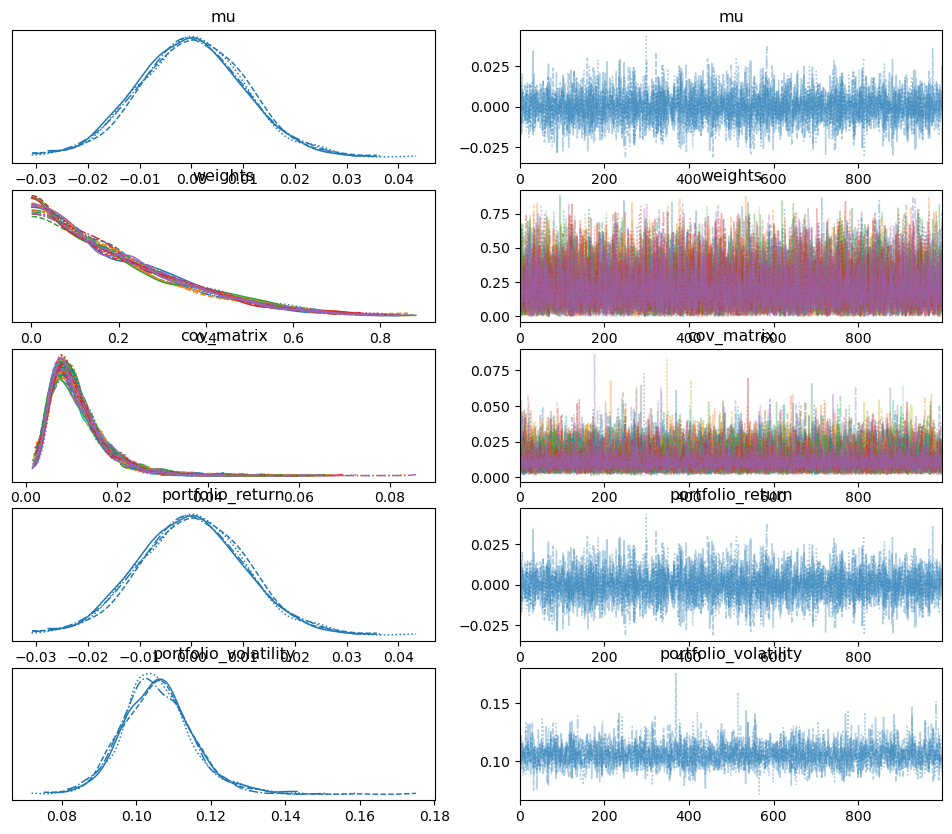

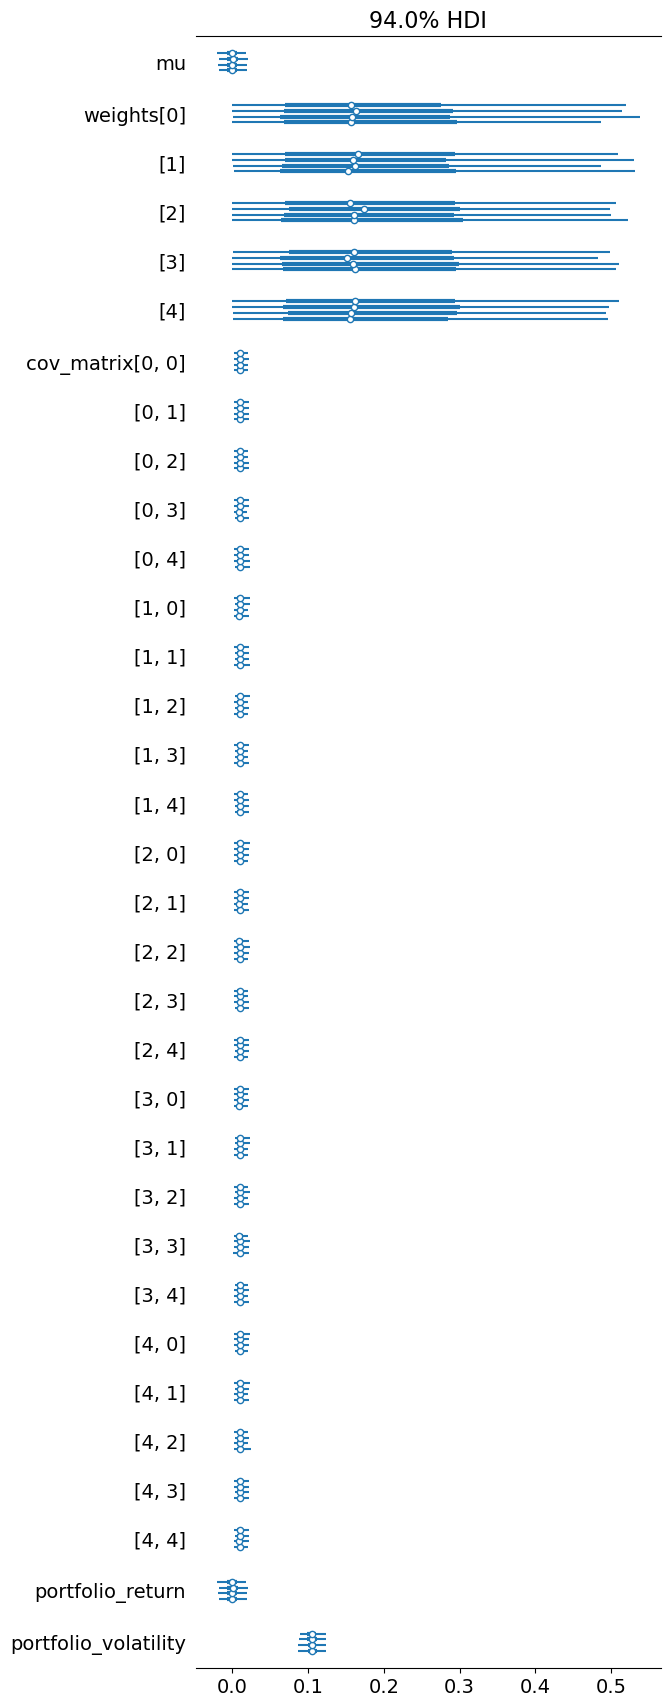

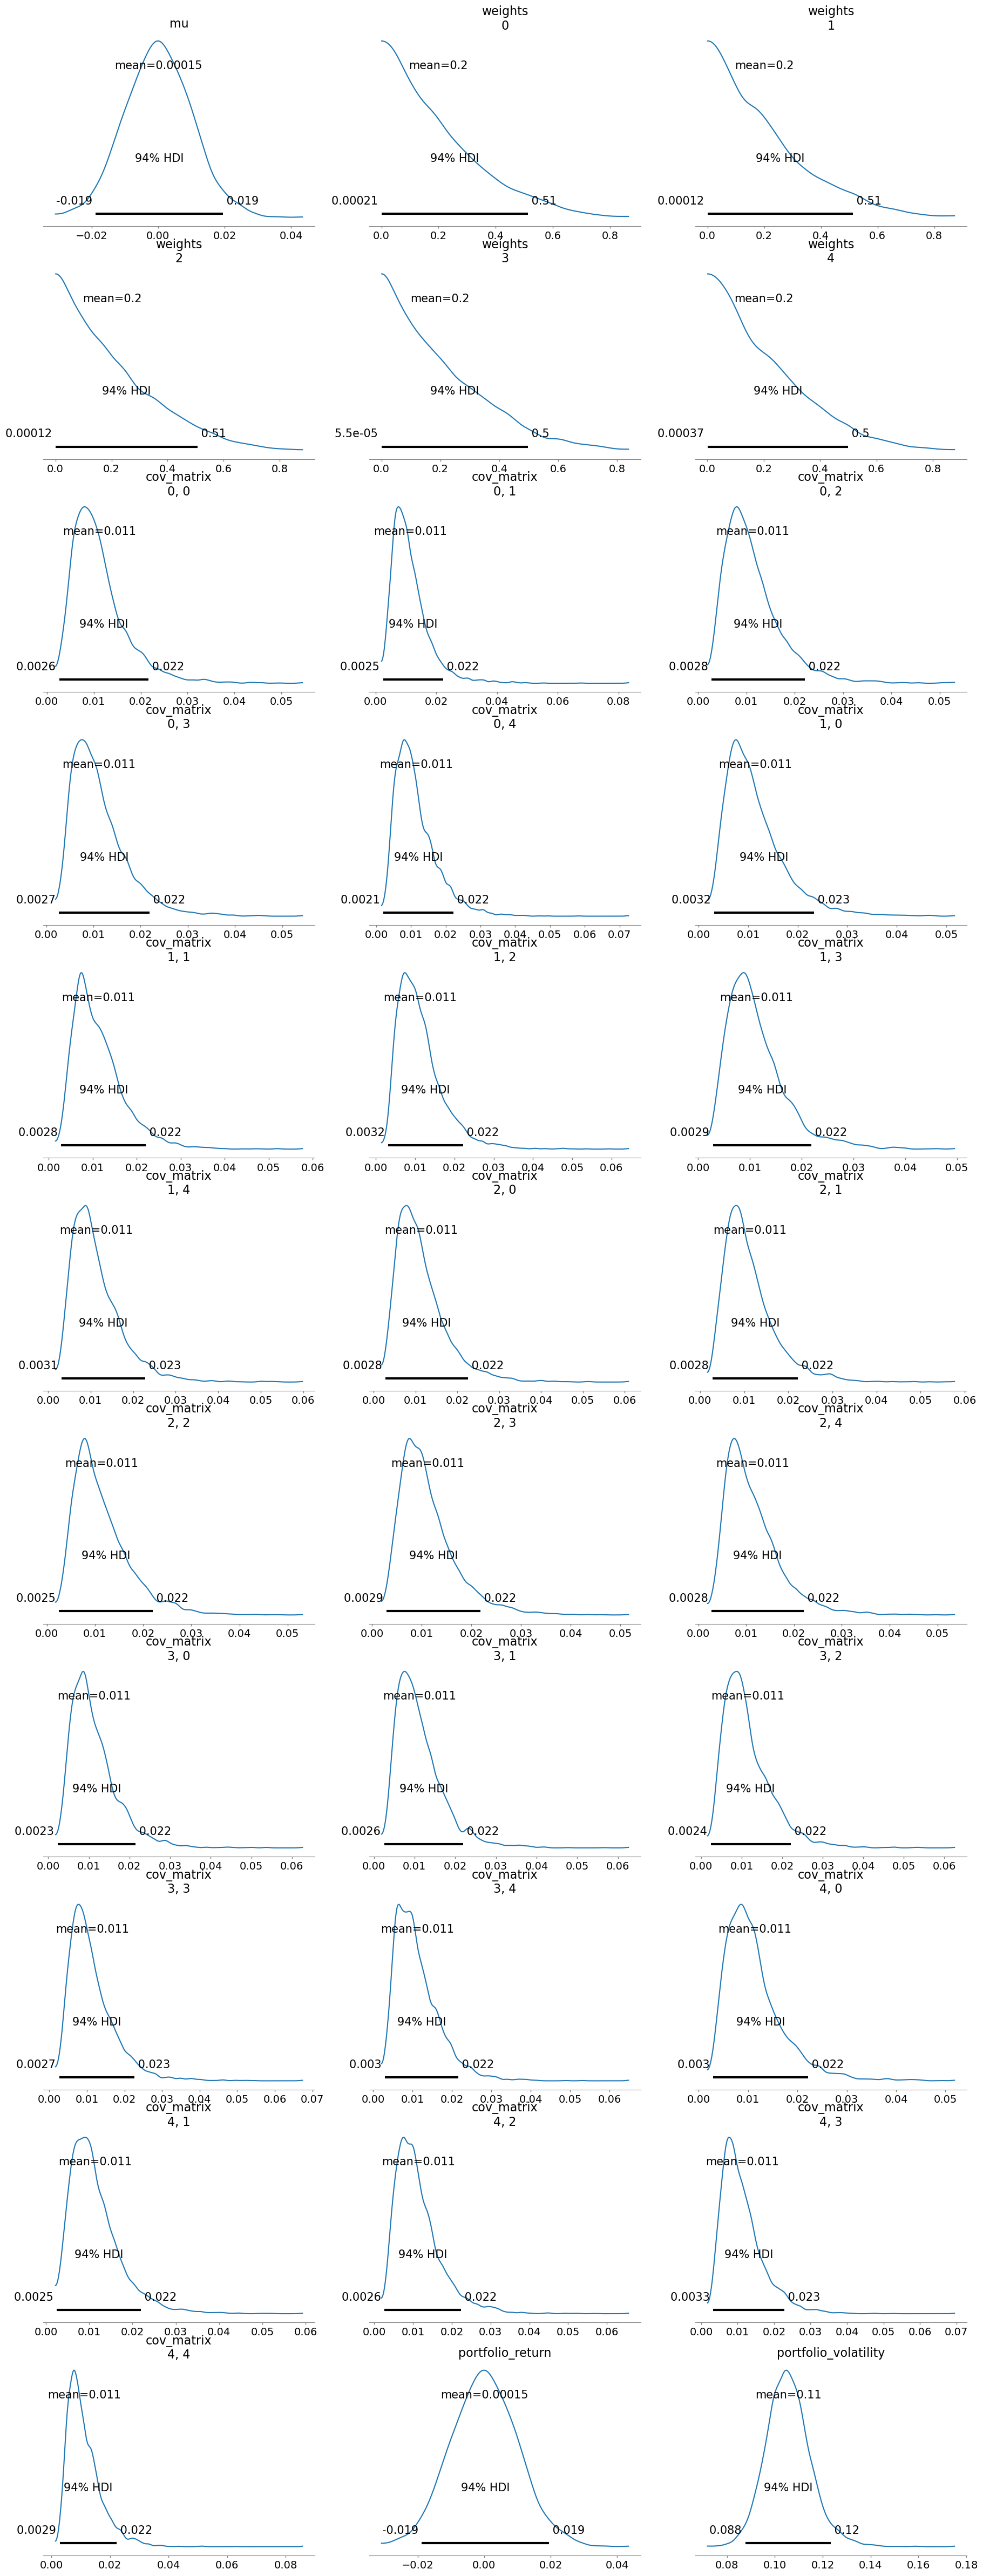

In [17]:
import arviz as az
_ =  az.plot_trace(idata)
_ =  az.plot_forest(idata)
_ =  az.plot_posterior(idata)

In [18]:
# store subsetted inferencedata
thinned_idata = idata.sel(draw=slice(None, None, 10))
with portfolio_model:
    idata.extend(pm.sample_posterior_predictive(thinned_idata))


In [22]:
thinned_idata.to_dataframe().columns

Index([                                  'chain',
                                          'draw',
                             ('posterior', 'mu'),
                  ('posterior', 'weights[0]', 0),
                  ('posterior', 'weights[1]', 1),
                  ('posterior', 'weights[2]', 2),
                  ('posterior', 'weights[3]', 3),
                  ('posterior', 'weights[4]', 4),
          ('posterior', 'cov_matrix[0,0]', 0, 0),
          ('posterior', 'cov_matrix[0,1]', 0, 1),
          ('posterior', 'cov_matrix[0,2]', 0, 2),
          ('posterior', 'cov_matrix[0,3]', 0, 3),
          ('posterior', 'cov_matrix[0,4]', 0, 4),
          ('posterior', 'cov_matrix[1,0]', 1, 0),
          ('posterior', 'cov_matrix[1,1]', 1, 1),
          ('posterior', 'cov_matrix[1,2]', 1, 2),
          ('posterior', 'cov_matrix[1,3]', 1, 3),
          ('posterior', 'cov_matrix[1,4]', 1, 4),
          ('posterior', 'cov_matrix[2,0]', 2, 0),
          ('posterior', 'cov_matrix[2,1]', 2, 1),


In [20]:
d_fd

NameError: name 'd_fd' is not defined

In [21]:
# do not store it
with portfolio_model:
    idata.extend(pm.sample_posterior_predictive(
        idata.sel(draw=slice(None, None, 5))
))

In [27]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generating synthetic data
np.random.seed(42)
num_samples = 1000
X = np.random.randn(num_samples, 2)  # Example features (2 variables)
true_beta = np.array([0.5, 1.2])  # True coefficients
epsilon = 0.5 * np.random.randn(num_samples)  # Error term
Y = np.dot(X, true_beta) + epsilon  # True relationship + noise

# Model specification
with pm.Model() as model:
    # Priors on regression coefficients
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])  # Assuming normal prior
    
    # Define likelihood - assuming a simple linear model
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal('sigma', sd=1)  # Assumed half-normal prior for variance
    likelihood = pm.Normal('Y', mu=mu, sd=sigma, observed=Y)
    
    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, cores=1)  # MCMC sampling
    
# Prediction
# Extracting posterior samples for beta and sigma
posterior_samples = pm.trace_to_dataframe(trace)
betas = posterior_samples[['beta__{}'.format(i) for i in range(X.shape[1])]].values
sigma_samples = posterior_samples['sigma'].values

# Calculating predicted volatility (using some function of betas and inputs)
# This will depend on your specific model formulation
predicted_volatility = ...  # Calculate predicted volatility based on betas and inputs

# Plotting posterior distributions of coefficients
pm.plot_posterior(trace, var_names=['beta'], figsize=(10, 6))
plt.show()


TypeError: RandomVariable.make_node() got an unexpected keyword argument 'sd'